# MOSFET gm/ID Evaluation Script for GF180MCU

**Copyright 2024 Boris Murmann and Harald Pretl**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0

This notebook displays various important metrics for the SG13G2 CMOS technology. The corresponding Xschem testbenches are named `techsweep_sg13g2_lv_nmos.sch` and `techsweep_sg13g2_lv_pmos.sch` (to be found in the `xschem` folder).

In [1]:
devices = ['gf180_nmos', 'gf180_pmos']
choice = 0 # select which device to plot, start from 0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
# widths used for characterization

In [3]:
# Unit conversion map
unit_multipliers = {
    'p': 1e-12,
    'n': 1e-9,
    'u': 1e-6,
    'm': 1e-3,
    '': 1.0  # for unitless or base values
}

def parse_value_with_unit(s):
    """Convert strings like '100m' or '1u' to float values."""
    match = re.match(r"([0-9.]+)([pnum]?)", s)
    if match:
        value, unit = match.groups()
        return float(value) * unit_multipliers.get(unit, 1.0)
    return None

In [4]:
# Replace with your actual CSV file path
input_csv = "gmId_{}.csv".format(devices[choice])
df = pd.read_csv(input_csv)

# Store reformatted blocks
records = []
current_params = {}

for _, row in df.iterrows():
    point_value = str(row['Point'])
    
    if point_value.startswith("Parameters:"):
        # Save the previous block if it exists
        if current_params:
            records.append(current_params)
        
        # Extract and convert Vd and Vg
        vd_match = re.search(r"Vd=([\d\.]+[pnum]?)", point_value)
        vg_match = re.search(r"Vg=([\d\.]+[pnum]?)", point_value)
        length_match = re.search(r"length=([\d\.]+[pnum]?)", point_value)
        width_match = re.search(r"width=([\d\.]+[pnum]?)", point_value)
#        vd = parse_value_with_unit(vd_match.group(1)) if vd_match else None
#        vg = parse_value_with_unit(vg_match.group(1)) if vg_match else None
        length = parse_value_with_unit(length_match.group(1)) if length_match else None
        width = parse_value_with_unit(width_match.group(1)) if width_match else None

        # Start new block with parsed parameters
        current_params = {
            'l': length,
            'w': width
        }
        
    elif pd.notna(row['Output']) and pd.notna(row['Nominal']):
        current_params[row['Output']] = row['Nominal']

# Append the last block
if current_params:
    records.append(current_params)

# Convert to DataFrame
output_df = pd.DataFrame(records)
output_df = output_df.iloc[:,:-2] # drop the derived parameters

# rename columns with OP and quotations
for column in output_df.columns:
    if not re.findall('"([^"]*)"', column):
        True
    else:
        new_column_name = re.findall('"([^"]*)"', column)[1]
        output_df.rename(columns={column: new_column_name}, inplace=True)


# Save or print
output_df.to_csv("gm_ID_reorganized.csv", index=False)
print(output_df)

                 l             w           gds            id           fug  \
0     9.000000e-08  1.200000e-07  6.055000e-11  1.976000e-11  1.829000e+06   
1     9.000000e-08  2.400000e-07  7.350000e-11  2.335000e-11  1.080000e+06   
2     9.000000e-08  4.800000e-07  9.734000e-11  3.066000e-11  7.080000e+05   
3     9.000000e-08  1.000000e-06  1.474000e-10  4.631000e-11  5.123000e+05   
4     9.000000e-08  1.200000e-07  1.439000e-09  4.782000e-10  4.184000e+07   
...            ...           ...           ...           ...           ...   
2299  1.000000e-06  1.000000e-06  5.657000e-06  8.470000e-05  2.952000e+09   
2300  1.000000e-06  1.200000e-07  9.967000e-07  1.363000e-05  3.073000e+09   
2301  1.000000e-06  2.400000e-07  1.883000e-06  2.664000e-05  3.103000e+09   
2302  1.000000e-06  4.800000e-07  3.650000e-06  5.204000e-05  3.150000e+09   
2303  1.000000e-06  1.000000e-06  7.348000e-06  1.058000e-04  3.114000e+09   

         vgt            gm  gmoverid  vgs  vds           cgg   

In [5]:
# read ngspice data
df = pd.read_csv('./gm_ID_reorganized.csv')
par_names = df.columns.to_list()

# remove extra headers in file body and unwanted columns
df = df.apply(pd.to_numeric)

# round sweep vectors to easily addressable values
#df['l'] = df['l'].apply(lambda x: round(x/1e-6, 3))
df['l'] = df['l'].apply(lambda x: round(x/1e-9, 3))
df['w'] = df['w'].apply(lambda x: round(x/1e-9, 3))


# some stupid additions to reuse the already there scripts
df['ids'] = df['id']
df['vsb'] = df['vbs']

print(df.columns)
# Note on noise data: 
# 1.: sid, sfl are thermal and flicker noise current densities at 1 Hz in A^2/Hz from operating point data

Index(['l', 'w', 'gds', 'id', 'fug', 'vgt', 'gm', 'gmoverid', 'vgs', 'vds',
       'cgg', 'vth', 'vbs', 'cgs', 'ids', 'vsb'],
      dtype='object')


In [6]:
# sweep variable vectors
l = np.unique(abs(df['l']))
w = np.unique(abs(df['w']))
vgs = np.unique(abs(df['vgs']))
vds = np.unique(abs(df['vds']))
vsb = np.unique(abs(df['vsb']))
print(w)

[ 120.  240.  480. 1000.]


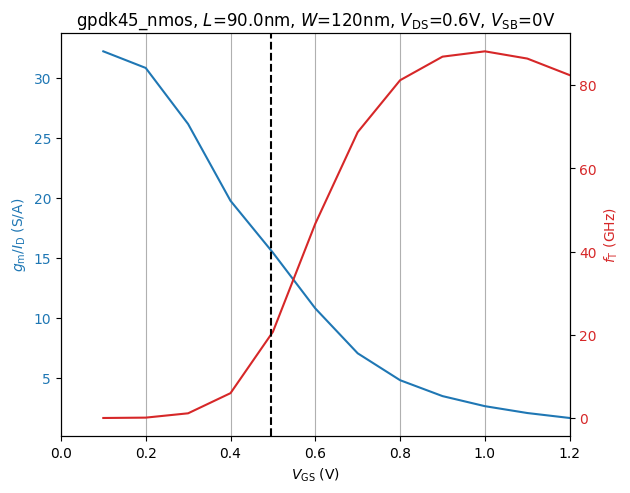

In [7]:
# plot gm/ID and fT versus gate bias
#| label: fig-nmos-gmid-ft-vs-vgs
#| fig-cap: $g_m/I_D$ and $f_T$ as a function of the gate-source voltage.
L1 = min(l); W1 = 120; VDS1=0.6; VSB1=0
df1 = df.loc[(df['l'] == L1) & (df['w'] == W1) & (abs(df['vds']) == VDS1) & (abs(df['vsb']) == VSB1)]
gm_id1 = df1['gm'].values/df1['ids'].values
cgg1 = df1['cgg'].values
ft1 = df1['gm'].values/cgg1/2/np.pi
ft2 = df1['fug'].values

fig, ax1 = plt.subplots()
ax1.grid(axis='x')
ax1.set_xlabel(r'$V_\mathrm{GS}$ (V)')
color = 'tab:blue'
ax1.set_ylabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)', color=color)
ax1.plot(vgs, gm_id1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'$f_\mathrm{T}$ (GHz)', color=color)
ax2.plot(vgs, ft2/1e9, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title(devices[choice]+', $L$='+str(L1) + 'nm, $W$='+str(W1) + r'nm, $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.axvline(x = df1['vth'].values[0], color='k', linestyle='--')
plt.xlim(0, 1.2)
plt.show()
fig.savefig("./NMOS_gmID_fT_VGS.eps", bbox_inches='tight')
fig.savefig("./NMOS_gmID_fT_VGS.png", bbox_inches='tight')

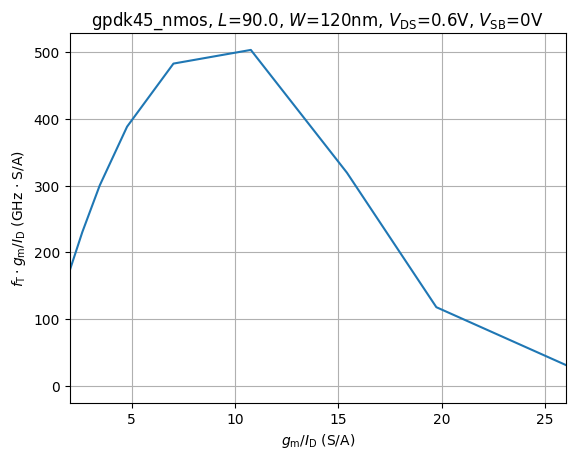

In [8]:
# plot product of gm/ID and fT versus gm/ID
fig, ax1 = plt.subplots()
plt.plot(gm_id1, gm_id1*ft1/1e9)
plt.xlim(2, 26)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$f_\mathrm{T} \cdot g_\mathrm{m}/I_\mathrm{D}$ (GHz $\cdot$ S/A)')
plt.title(devices[choice]+', $L$='+str(L1) + ', $W$='+str(W1) +r'nm, $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.grid()
plt.show()
fig.savefig("./NMOS_fTgmID_gmID.eps", bbox_inches='tight')
fig.savefig("./NMOS_fTgmID_gmID.png", bbox_inches='tight')

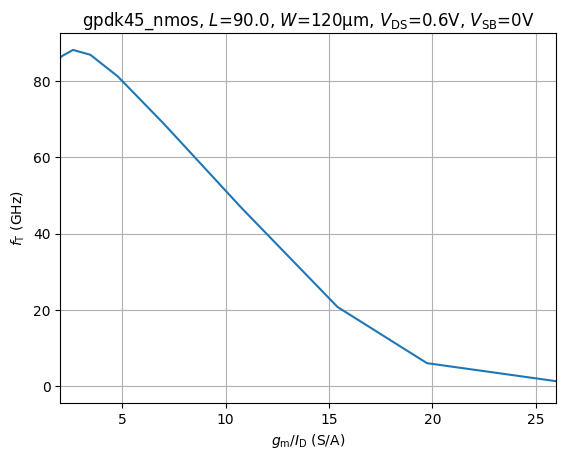

In [9]:
# plot fT versus gm/ID
#| label: fig-nmos-ft-vs-gmid
#| fig-cap: $f_T$ vs. $g_m/I_D$.
plt.plot(gm_id1, ft1/1e9)
plt.xlim(2, 26)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$f_\mathrm{T}$ (GHz)')
plt.title(devices[choice]+', $L$='+str(L1)+', $W$='+str(W1)+r'µm, $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.grid()
plt.show()
fig.savefig("./NMOS_fT_gmID.eps", bbox_inches='tight')
fig.savefig("./NMOS_fT_gmID.png", bbox_inches='tight')

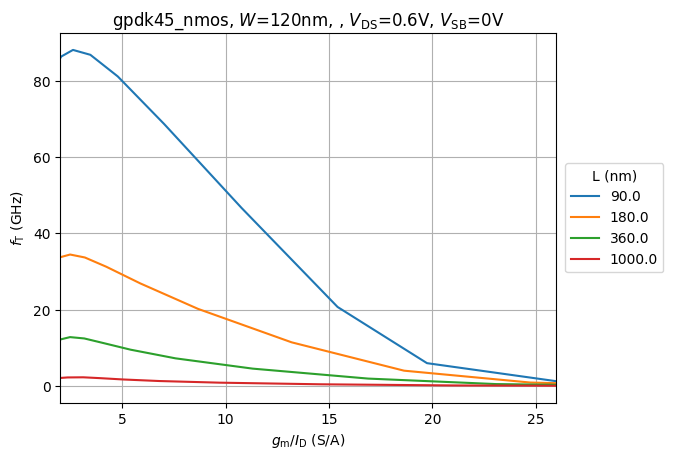

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
# plot fT versus gm/ID for all L
#| label: fig-nmos-ft-vs-gmid-vs-l
#| fig-cap: $f_T$ vs. $g_m/I_D$ as a function of $L$.
VDS2=0.6; VSB2=0; W2=120
df2 = df.loc[(abs(df['vds']) == VDS2) & (abs(df['vsb']) == VSB2) & (df['w'] == W2)]
gm_id2 = df2['gm'].values/df2['ids'].values
gm_id2 = np.reshape(gm_id2, (len(vgs), -1), order='F')
ft2 = df2['fug']
ft2 = np.reshape(ft2, (len(vgs), -1), order='F')

fig, ax = plt.subplots()
ax.plot(gm_id2, ft2/1e9)
ax.legend(loc='center right', bbox_to_anchor=(1.23, 0.5), title='L (nm)', labels=l.tolist())
plt.xlim(2, 26)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$f_\mathrm{T}$ (GHz)')
plt.title(devices[choice]+', $W$='+str(W2) +r'nm, ' + r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.grid()
plt.show()

fig.savefig("./NMOS_fT_gmID.eps", bbox_inches='tight')
fig.savefig("./NMOS_fT_gmID.png", bbox_inches='tight')

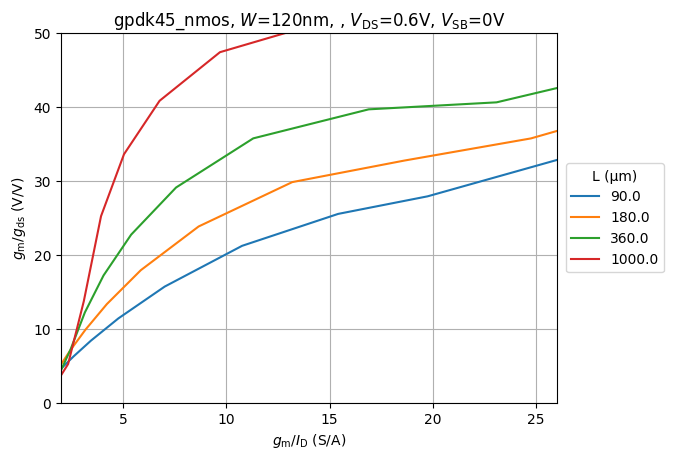

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [11]:
# plot gm/gds versus gm/ID for all L
#| label: fig-nmos-gmgds-vs-gmid-vs-l
#| fig-cap: $g_m/g_{ds}$ vs. $g_m/I_D$ as a function of $L$.
gm_gds2 = df2['gm'].values/df2['gds'].values
gm_gds2 = np.reshape(gm_gds2, (len(vgs), -1), order='F')

fig, ax = plt.subplots()
ax.plot(gm_id2, gm_gds2)
ax.legend(loc='center right', bbox_to_anchor=(1.23, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
plt.ylim(0, 50)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$g_\mathrm{m}/g_\mathrm{ds}$ (V/V)')
plt.title(devices[choice]+', $W$='+str(W2) +r'nm, ' +r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.grid()
plt.show()
fig.savefig("./NMOS_gmgds_gmID.eps", bbox_inches='tight')
fig.savefig("./NMOS_gmgds_gmID.png", bbox_inches='tight')

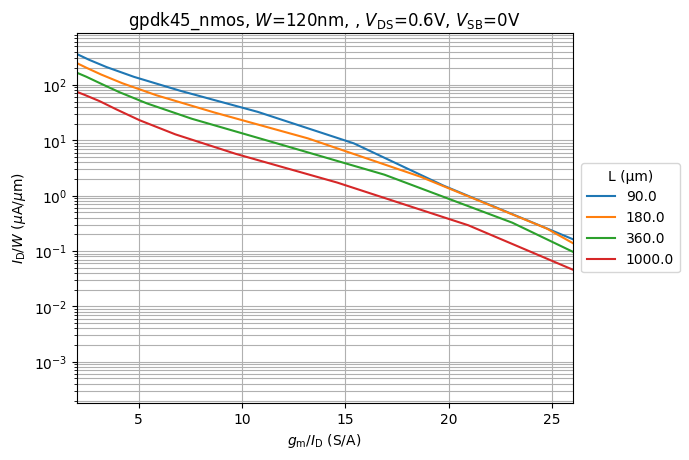

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [16]:
# plot Id/W (Jd) versus gm/ID for all L
#| label: fig-nmos-jd-vs-gmid-vs-l
#| fig-cap: $I_D/W$ vs. $g_m/I_D$ as a function of $L$.
jd2 = df2['ids'].values/(df2['w'].values*1e-9)
jd2 = np.reshape(jd2, (len(vgs), -1), order='F')

fig, ax = plt.subplots()
ax.semilogy(gm_id2, jd2)
ax.legend(loc='center right', bbox_to_anchor=(1.23, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
#if choice == 0:
#    plt.ylim(1e-2, 1e3)
#else:
#    plt.ylim(1e-2,1e3)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$I_\mathrm{D}/W$ ($\mu$A/$\mu$m)')
plt.grid(which='minor')
plt.grid(which='major')
plt.title(devices[choice]+', $W$='+str(W2) +r'nm, ' +r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.show()
fig.savefig("./NMOS_IDW_gmID.eps", bbox_inches='tight')
fig.savefig("./NMOS_IDW_gmID.png", bbox_inches='tight')

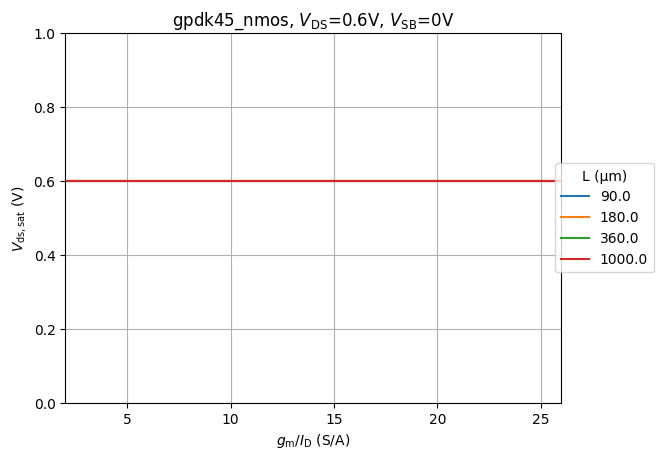

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
# plot Vdss versus gm/ID for all L
#| label: fig-nmos-vdsat-vs-gmid-vs-l
#| fig-cap: $V_{ds,sat}$ vs. $g_m/I_D$ as a function of $L$.
vdss2 = df2['vds']
vdss2 = np.reshape(vdss2, (len(vgs), -1), order='F')
fig, ax = plt.subplots()
ax.plot(gm_id2, vdss2)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
plt.ylim(0, 1)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$V_\mathrm{ds,sat}$ (V)')
plt.grid(which='minor')
plt.grid(which='major')
plt.title(devices[choice]+r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.show()
fig.savefig("./NMOS_Vdssat_gmID.eps", bbox_inches='tight')

In [31]:
# plot gamm versus gm/ID for all L
#| label: fig-nmos-gamma-vs-gmid-vs-l
#| fig-cap: $\gamma$ vs. $g_m/I_D$ as a function of $L$.
sid2 = df2['sid'].values
gm2 = df2['gm'].values
sid2 = np.reshape(sid2, (len(vgs), -1), order='F')
gm2 = np.reshape(gm2, (len(vgs), -1), order='F')
gamma2 = sid2/4/1.38e-23/300/gm2

fig, ax = plt.subplots()
ax.plot(gm_id2, gamma2)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
if choice == 0:
    plt.ylim(0.6,1.2)
else:
    plt.ylim(1,2.5)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'Noise factor $\gamma$ (1)')
plt.grid(which='minor')
plt.grid(which='major')
plt.title(devices[choice]+r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.show()
fig.savefig("techsweep_sg13_plots_nmos_overview/plots/NMOS_gamma_gmID.eps", bbox_inches='tight')

KeyError: 'sid'

In [ ]:
# plot fco versus gm/ID for all L
#| label: fig-nmos-fco-vs-gmid-vs-l
#| fig-cap: Flicker-noise corner frequency vs. $g_m/I_D$ as a function of $L$.
sfl2 = df2['sfl'].values
sfl2 = np.reshape(sfl2, (len(vgs), -1), order='F')
fco = sfl2/sid2
fig, ax = plt.subplots()
ax.semilogy(gm_id2, fco)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
plt.ylim(1e2, 1e8)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$f_\mathrm{co}$ (Hz)')
plt.grid(which='minor')
plt.grid(which='major')
plt.title(devices[choice]+r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.show()
fig.savefig("techsweep_sg13_plots_nmos_overview/plots/NMOS_fco_gmID.eps", bbox_inches='tight')